In [1]:
# 1. Add paths and import env variables
import sys
from os import environ
database_uri = environ['DATABASE_URI']
sys.path.insert(0, '/app')
sys.path.insert(0, '/data')

In [2]:
# 2. Imports and topic setup
import string
import spacy
import numpy as np
import matplotlib.pyplot as plt

from time import time

from sqlalchemy import create_engine, ForeignKey, Column, Integer, String, Text, select
from sqlalchemy.orm import declarative_base, relationship, Session

from articles_orm import Base, Article, ArticleFeatures
from utils import read_file_content, money_merger, print_topics, plot_top_words, get_recommendation

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel


topic_list = read_file_content('/data/topics.txt')
en_stopwords = read_file_content('/data/stopwords_en.txt')

print(topic_list)

['crypto', 'bitcoin', 'covid', 'vaccine', 'startups', 'technology', 'e-commerce', 'Nokia', 'Apple', 'Microsoft']


In [3]:
# 3. Setup engine to database.
engine = create_engine(database_uri)

In [4]:
# 4. Query all articles
with Session(engine) as session:
    articles = session.query(Article).all()
print(len(articles))
print(articles[-1].id)

717
717


In [5]:
# 5. For every article from db, preprocess text
# (preprocessing: punctuation and stopwords removal, numericals extraction, lemmatization, NER)
nlp = spacy.load('en_core_web_md')
#nlp.remove_pipe("lemmatizer")
#nlp.add_pipe("lemmatizer", config={"mode": "lookup"}).initialize()
nlp.add_pipe("merge_entities")
nlp.add_pipe('money_merger', after='ner')

additional_remove_chars = "'\"`—“’”\n"
punctuation = string.punctuation.replace('-','')+additional_remove_chars

articles_lt = []
articles_features = []
for article in articles:
    # preprocess
    article_features = {}
    article_doc = nlp(article.maintext)
    article_doc = money_merger(article_doc)
    lemmas = [token.lemma_ for token in article_doc 
              if 
              token.lemma_ not in en_stopwords 
              and token.lemma_ not in punctuation]
    # pull out number of numericals as a feature of its own
    article_numericals = [lemma for lemma in lemmas if any(char.isdigit() for char in lemma)]
    # clean original lemmas from numericals
    lemmas = [lemma for lemma in lemmas if not any(char.isdigit() for char in lemma)]
    # pull out named entities as a feature of its own
    named_entities = {ent.label_: set([ent.text for inent in article_doc.ents if 
                                   inent.label_ == ent.label_]) for ent in article_doc.ents}
    article_lemmatized = ' '.join(lemmas)
    article_features['article_id'] = article.id
    article_features['named_entities'] = named_entities
    article_features['num_numericals'] = len(article_numericals)
    article_features['lemmatized_text'] = article_lemmatized
    articles_features += [article_features]
    articles_lt += [article_lemmatized]
print(articles_features)
print(articles_lt)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
# 6. TfIdf with bigrams
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             sublinear_tf=True, 
                             use_idf=True, 
                             stop_words=en_stopwords, 
                             min_df=0.001, 
                             max_df=0.85)
tf = vectorizer.fit_transform(articles_lt)
feature_names = vectorizer.get_feature_names()
# Print the shape of tf
print(tf.shape)
print(feature_names)
print(tf)

(717, 161847)
['aa', 'aa british', 'aa spaces', 'aac', 'aac sbc', 'aakash', 'aakash continue', 'aakash educational', 'aamer', 'aamer madhani', 'aamva', 'aamva check', 'aap', 'aap active', 'aap careerist', 'aapl', 'aapl apple', 'aapl decade', 'aapl expect', 'aapl forecast', 'aapl google', 'aapl microsoft', 'aapl privacy', 'aapl report', 'aapl taiwan', 'aapl win', 'aargh', 'aargh simple', 'aaron', 'aaron rupar', 'aashish', 'aashish mehra', 'aasm', 'aasm share', 'aave', 'aave bitcoin', 'aave crypto', 'aave launch', 'aave quest', 'aave seek', 'aave top', 'ab', 'ab publ', 'abajo', 'abajo da', 'abandon', 'abandon cart', 'abandon culture', 'abandon endure', 'abandon exclusive', 'abandon product', 'abandon project', 'abandon search', 'abandon social', 'abandon suitable', 'abandon tab', 'abandon website', 'abandon xfinity', 'abandonment', 'abandonment exact', 'abandonment multiple', 'abandonment query', 'abate', 'abate chris', 'abate gbtc', 'abate sign', 'abb', 'abb airbus', 'abb bastian', 'abb

In [7]:
# 7.1. Principal Component Analysis 
# performed through Singular Value Decomposition applied on a TfIdf model renders Latent Semantic Indexing
svd5 = TruncatedSVD(n_components=5, random_state=289925)
svd10 = TruncatedSVD(n_components=10, random_state=289925)
svd50 = TruncatedSVD(n_components=50, random_state=289925)

t0 = time()
pca5 = svd5.fit(tf.toarray())
print(f"PCA5 fitted in {time() - t0}s")
t0 = time()
pca10 = svd10.fit(tf.toarray())
print(f"PCA10 fitted in {time() - t0}s")
t0 = time()
pca50 = svd50.fit(tf.toarray())
print(f"PCA50 fitted in {time() - t0}s")

t0 = time()
tf_svd5 = svd5.transform(tf)
print(f"PCA5 transformed in {time() - t0}s")
t0 = time()
tf_svd10 = svd10.transform(tf)
print(f"PCA10 transformed in {time() - t0}s")
t0 = time()
tf_svd50 = svd50.transform(tf)
print(f"PCA50 transformed in {time() - t0}s")

print(pca5.components_.shape)
print(tf_svd5.shape)
print(pca10.components_.shape)
print(tf_svd10.shape)
print(pca50.components_.shape)
print(tf_svd50.shape)

PCA5 fitted in 3.3665733337402344s
PCA10 fitted in 5.3181328773498535s
PCA50 fitted in 9.08182430267334s
PCA5 transformed in 0.006012439727783203s
PCA10 transformed in 0.007419586181640625s
PCA50 transformed in 0.04388928413391113s
(5, 161847)
(717, 5)
(10, 161847)
(717, 10)
(50, 161847)
(717, 50)


In [8]:
# 7.2. Nonnegative Matrix Factorization with Kullback-Leibler divergence
nmf5 = NMF(n_components=5, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)
nmf10 = NMF(n_components=10, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)
nmf50 = NMF(n_components=50, init='nndsvda', beta_loss='kullback-leibler', solver='mu', random_state=289925)

t0 = time()
nmf5.fit(tf)
print(f"NMF5 fitted in {time() - t0}s")
t0 = time()
nmf10.fit(tf)
print(f"NMF10 fitted in {time() - t0}s")
t0 = time()
nmf50.fit(tf)
print(f"NMF50 fitted in {time() - t0}s")

t0 = time()
tf_nmf5 = nmf5.transform(tf)
print(f"NMF5 transformed in {time() - t0}s")
t0 = time()
tf_nmf10 = nmf10.transform(tf)
print(f"NMF10 transformed in {time() - t0}s")
t0 = time()
tf_nmf50 = nmf50.transform(tf)
print(f"NMF50 transformed in {time() - t0}s")

print(nmf5.components_.shape)
print(tf_nmf5.shape)
print(nmf10.components_.shape)
print(tf_nmf10.shape)
print(nmf50.components_.shape)
print(tf_nmf50.shape)

NMF5 fitted in 3.4539918899536133s
NMF10 fitted in 3.1636054515838623s
NMF50 fitted in 10.45254898071289s
NMF5 transformed in 0.43781495094299316s
NMF10 transformed in 0.575143575668335s
NMF50 transformed in 1.360398769378662s
(5, 161847)
(717, 5)
(10, 161847)
(717, 10)
(50, 161847)
(717, 50)


In [9]:
# 7.3. Latent Dirichlet Allocation
cnt_vectorizer = CountVectorizer(ngram_range=(1,2), stop_words=en_stopwords, min_df=2, max_df=0.85)
cnt_tf = cnt_vectorizer.fit_transform(articles_lt)
lda5 = LatentDirichletAllocation(n_components=5, learning_method='online', random_state=289925)
lda10 = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=289925)
lda50 = LatentDirichletAllocation(n_components=50, learning_method='online', random_state=289925)

t0 = time()
lda5.fit(cnt_tf)
print(f"LDA5 fitted in {time()-t0}s")
t0 = time()
lda10.fit(cnt_tf)
print(f"LDA10 fitted in {time()-t0}s")
t0 = time()
lda50.fit(cnt_tf)
print(f"LDA50 fitted in {time()-t0}s")

t0 = time()
tf_lda5 = lda5.transform(cnt_tf)
print(f"LDA5 transformed in {time()-t0}s")
t0 = time()
tf_lda10 = lda10.transform(cnt_tf)
print(f"LDA10 transformed in {time()-t0}s")
t0 = time()
tf_lda50 = lda50.transform(cnt_tf)
print(f"LDA50 transformed in {time()-t0}s")

print(lda5.components_.shape)
print(tf_lda5.shape)
print(lda10.components_.shape)
print(tf_lda10.shape)
print(lda50.components_.shape)
print(tf_lda50.shape)

LDA5 fitted in 1.6980857849121094s
LDA10 fitted in 2.155479907989502s
LDA50 fitted in 6.258764743804932s
LDA5 transformed in 0.0921180248260498s
LDA10 transformed in 0.0970306396484375s
LDA50 transformed in 0.19015812873840332s
(5, 25404)
(717, 5)
(10, 25404)
(717, 10)
(50, 25404)
(717, 50)


In [10]:
# 8.1. Display 15 top words in each topic in each method
print("==PCA==")
print("==5==")
print_topics(pca5, feature_names)
print("==10==")
print_topics(pca10, feature_names)
print("==50==")
print_topics(pca50, feature_names)

print()
print("==NMF==")
print("==5==")
print_topics(nmf5, feature_names)
print("==10==")
print_topics(nmf10, feature_names)
print("==50==")
print_topics(nmf50, feature_names)

print()
print("==LDA==")
print("==5==")
print_topics(lda5, feature_names)
print("==10==")
print_topics(lda10, feature_names)
print("==50==")
print_topics(lda50, feature_names)

==PCA==
==5==
0 company, year, market, report, bitcoin, high, business, time, include, amazon, people, price, investor, share, well, 
1 cookie, load review, support javascript, javascript cookie, cookie policy, block load, service cookie, cookie block, happen browser, review term, browser support, term service, javascript, browser, block, 
2 circuitpython, adafruit, circuit playground, playground, circuit, alligator clip, makecode, python hardware, clip pad, arduino, alligator, python, pad, discord, clip, 
3 monday, stock, yield, fed, amazon, tuesday, rise, meeting, bitcoin, chinese, federal reserve, hong kong, kong, hong, wednesday, 
4 bitcoin, amazon, payment, accept bitcoin, bitcoin payment, accept, crypto, currency, speculation, digital currency, blockchain, cryptocurrency, spokesperson, currency blockchain, digital, 
==10==
0 company, year, market, report, bitcoin, high, business, time, include, amazon, people, price, investor, share, well, 
1 cookie, cookie policy, review term, h

40 beincrypto, story beincrypto, employee, realme, group, bitcoin, team, outflow, realme flash, story, magnetic, beincrypto join, signal free, free trading, trading course, 
41 hicaps, health, dose, apple wallet, administer, hicaps terminal, terminal, dose supply, till month, india administer, month dose, wallet, population, health insurance, insurance, 
42 asset, institution, realme, tokyo, invest, olympic, fund, games, investment, financial, send, olympics, trade, defi, realme flash, 
43 hashtag, add hashtag, hashtag picker, picker, tokyo, app badge, badge, update, relate attachment, hashtag task, attachment, task, app, ios, olympic, 
44 byon view, view fave, byon, fave, fave share, share byon, share, vertu, sm, earbud, view, facebook, active, sm marketing, mobiles, 
45 hashtag, people, add hashtag, hashtag picker, picker, pfizer, set report, apple tv, app, watch, lasso, ted lasso, frederick, ted, vaccine, 
46 cobalt, ipad, beincrypto, earbud, include, fund, apple, link, walled garde

2 bode ill, bring paint, advertisement decision, castro revolution, attachment, arrange configure, annual, add annual, aviator bush, accord verl, build hype, antitrust, christian hindu, care store, app update, 
3 accompany startup, amend rule, addition wearable, additionally startup, airbus couch, anc case, app activate, call industry, america open, breadcrumb allow, balmis set, broad liquidity, citilink, america hydration, americans, 
4 charge infrastructure, bloomberg remain, accumulation place, ai focus, check vaccine, apple refresh, add annual, apple registration, advise central, ai sense, app typically, business learn, adversary execute, appear occasionally, appear lose, 
5 ago official, absolutely explode, brown tough, ago number, ago microsoft, analysis organization, battersea well, bureaucratic, business operation, clear update, ahead cryptocurrency, brainstorm, acquire microsoft, big ol, accessibility hand, 
6 bill seek, airbus couch, closely journey, australia lockdown, call 

0

/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


For n_clusters = 5 The average silhouette_score is : 0.767764927810453


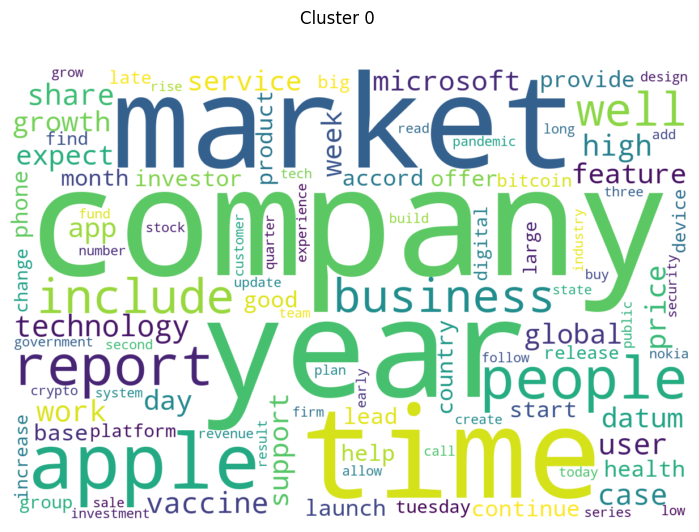

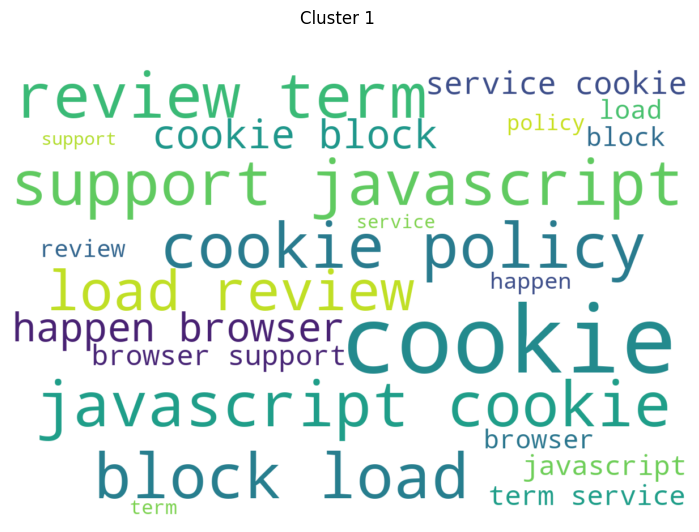

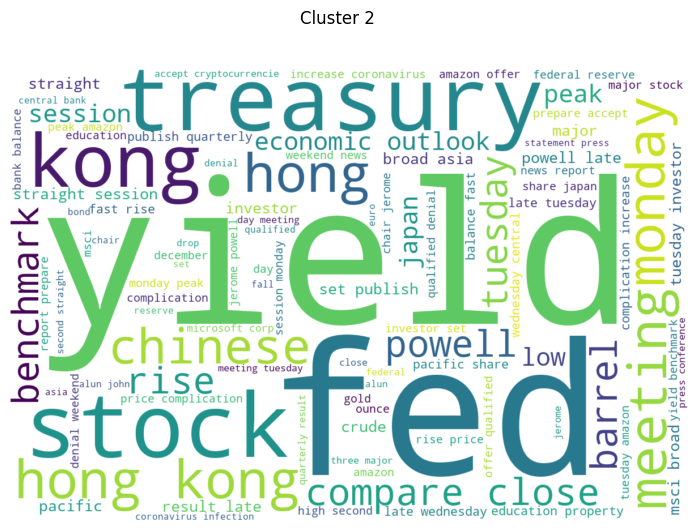

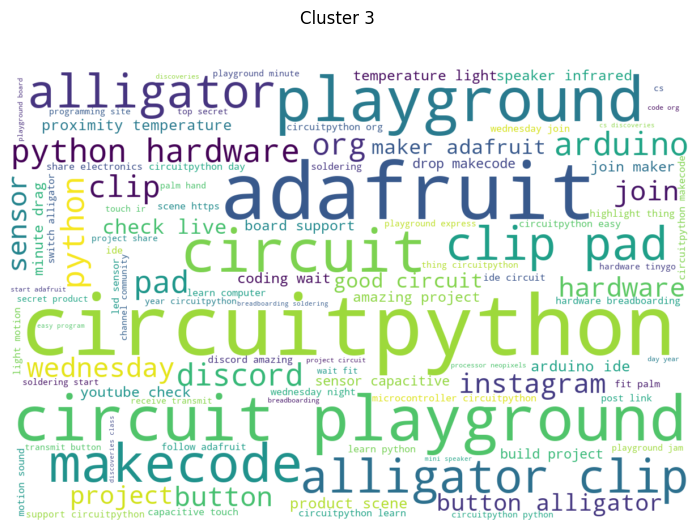

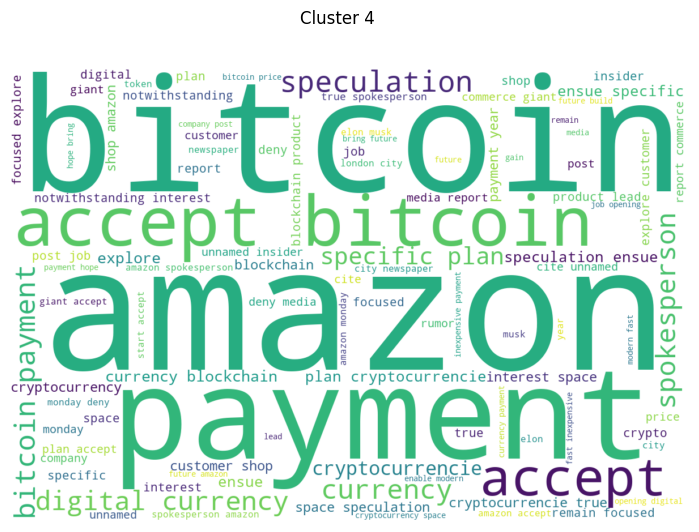

In [11]:
# 8.2. Show the topics as wordclouds -- TODO display the already made topics instead of additional clustering
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

def generate_wordclouds(X, in_X_tfidf, k, in_word_positions, file_prefix):

    # Clustering
    in_model = KMeans(n_clusters=k, random_state=289925, n_jobs=-1)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.savefig(f"{file_prefix}_cluster_{in_cluster_id}.png")
        plt.show()

    return in_cluster_ids


word_positions = {v: k for k, v in vectorizer.vocabulary_.items()}
_ = generate_wordclouds(tf_svd5, tf, 5, word_positions, "pca5")

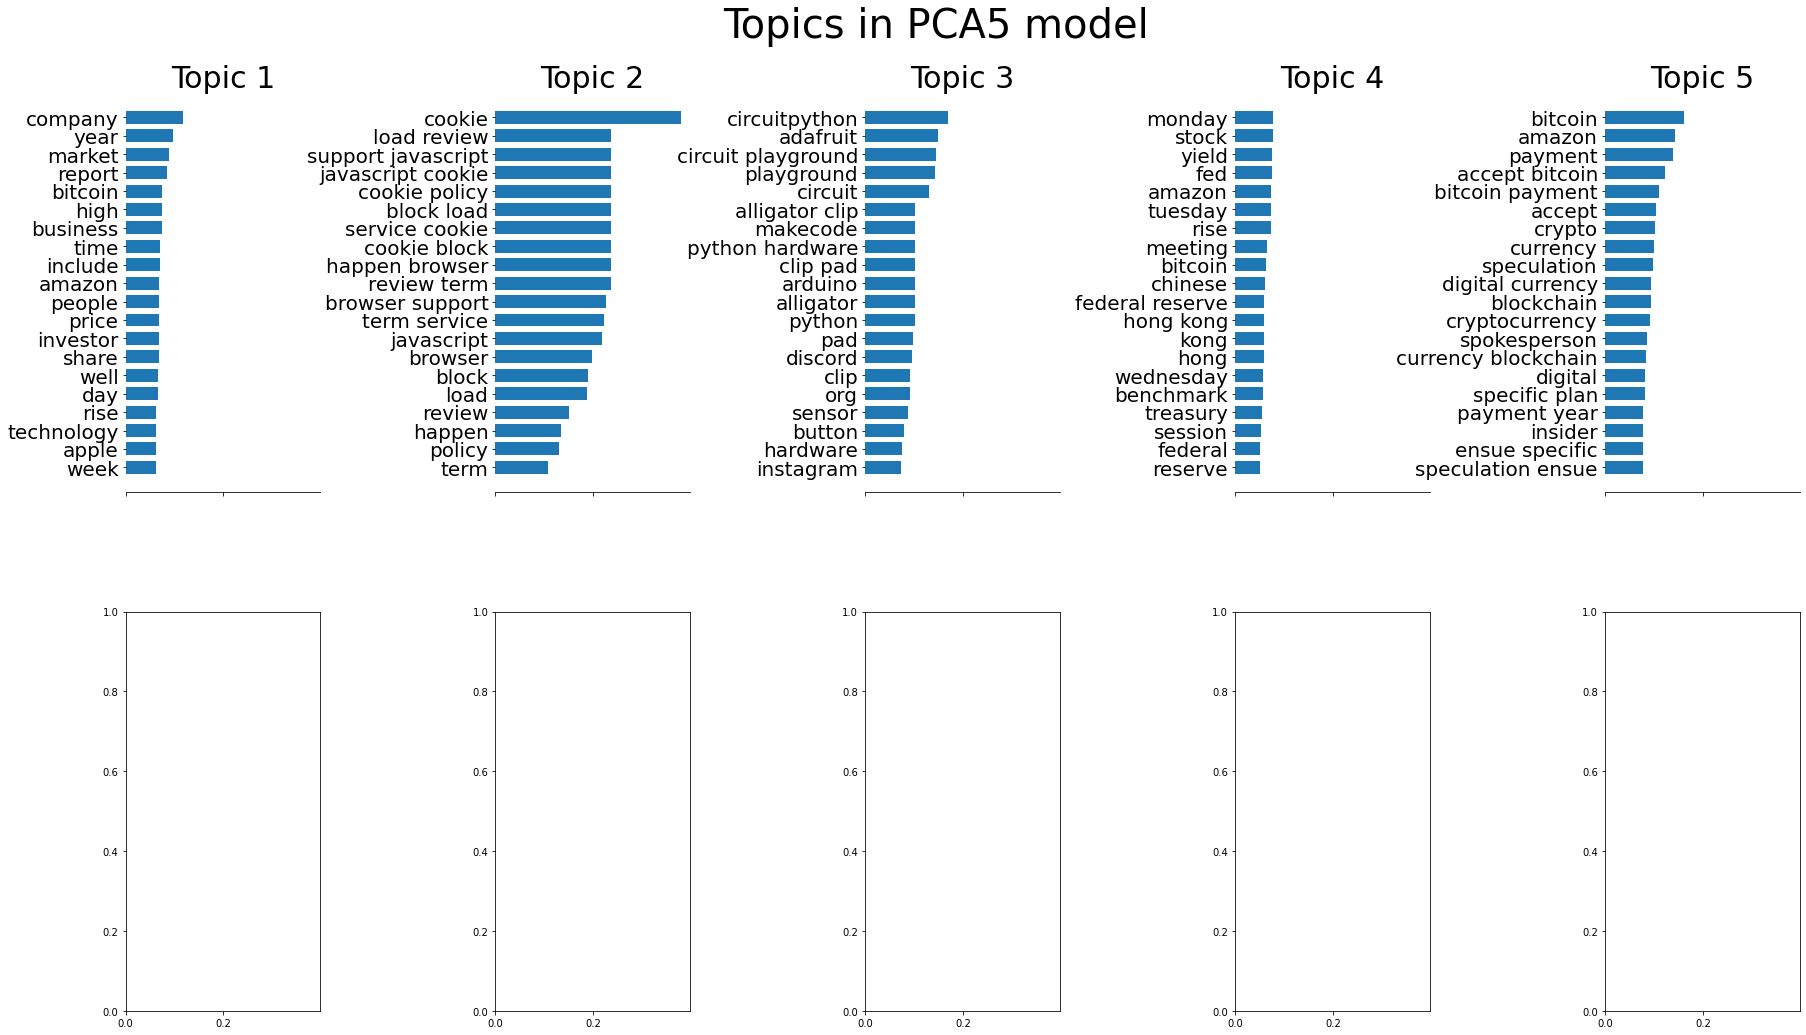

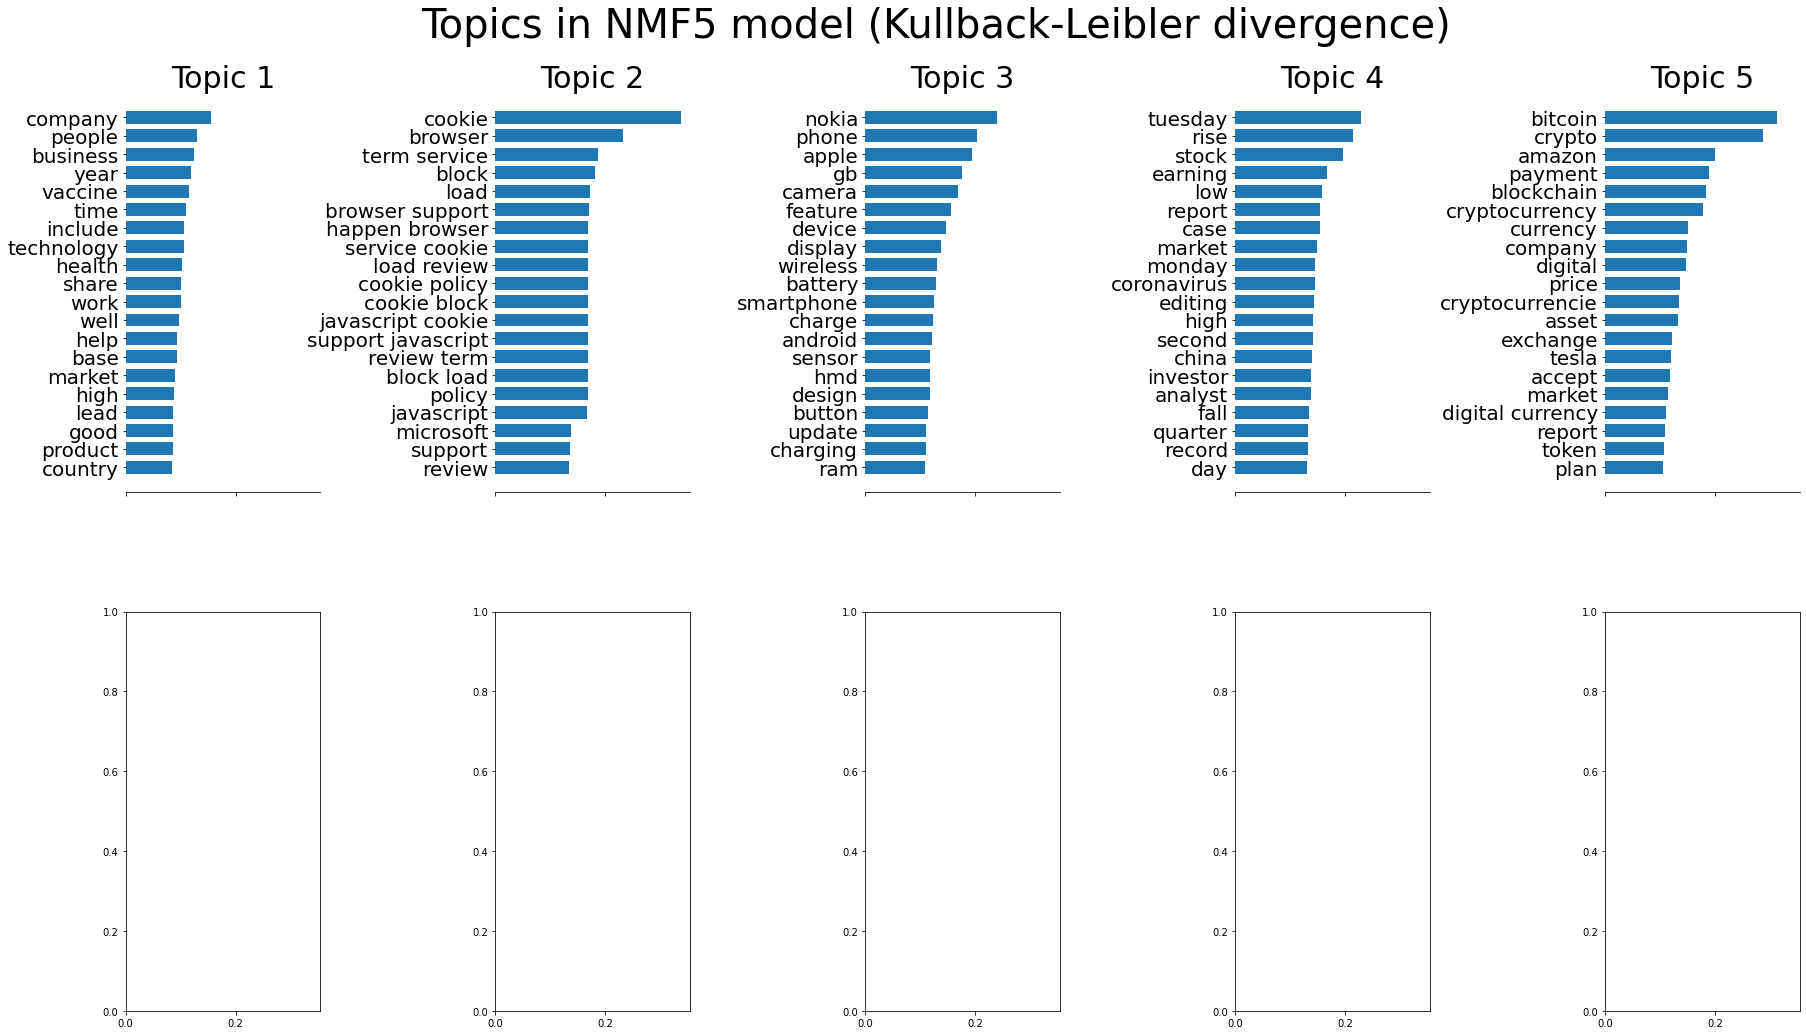

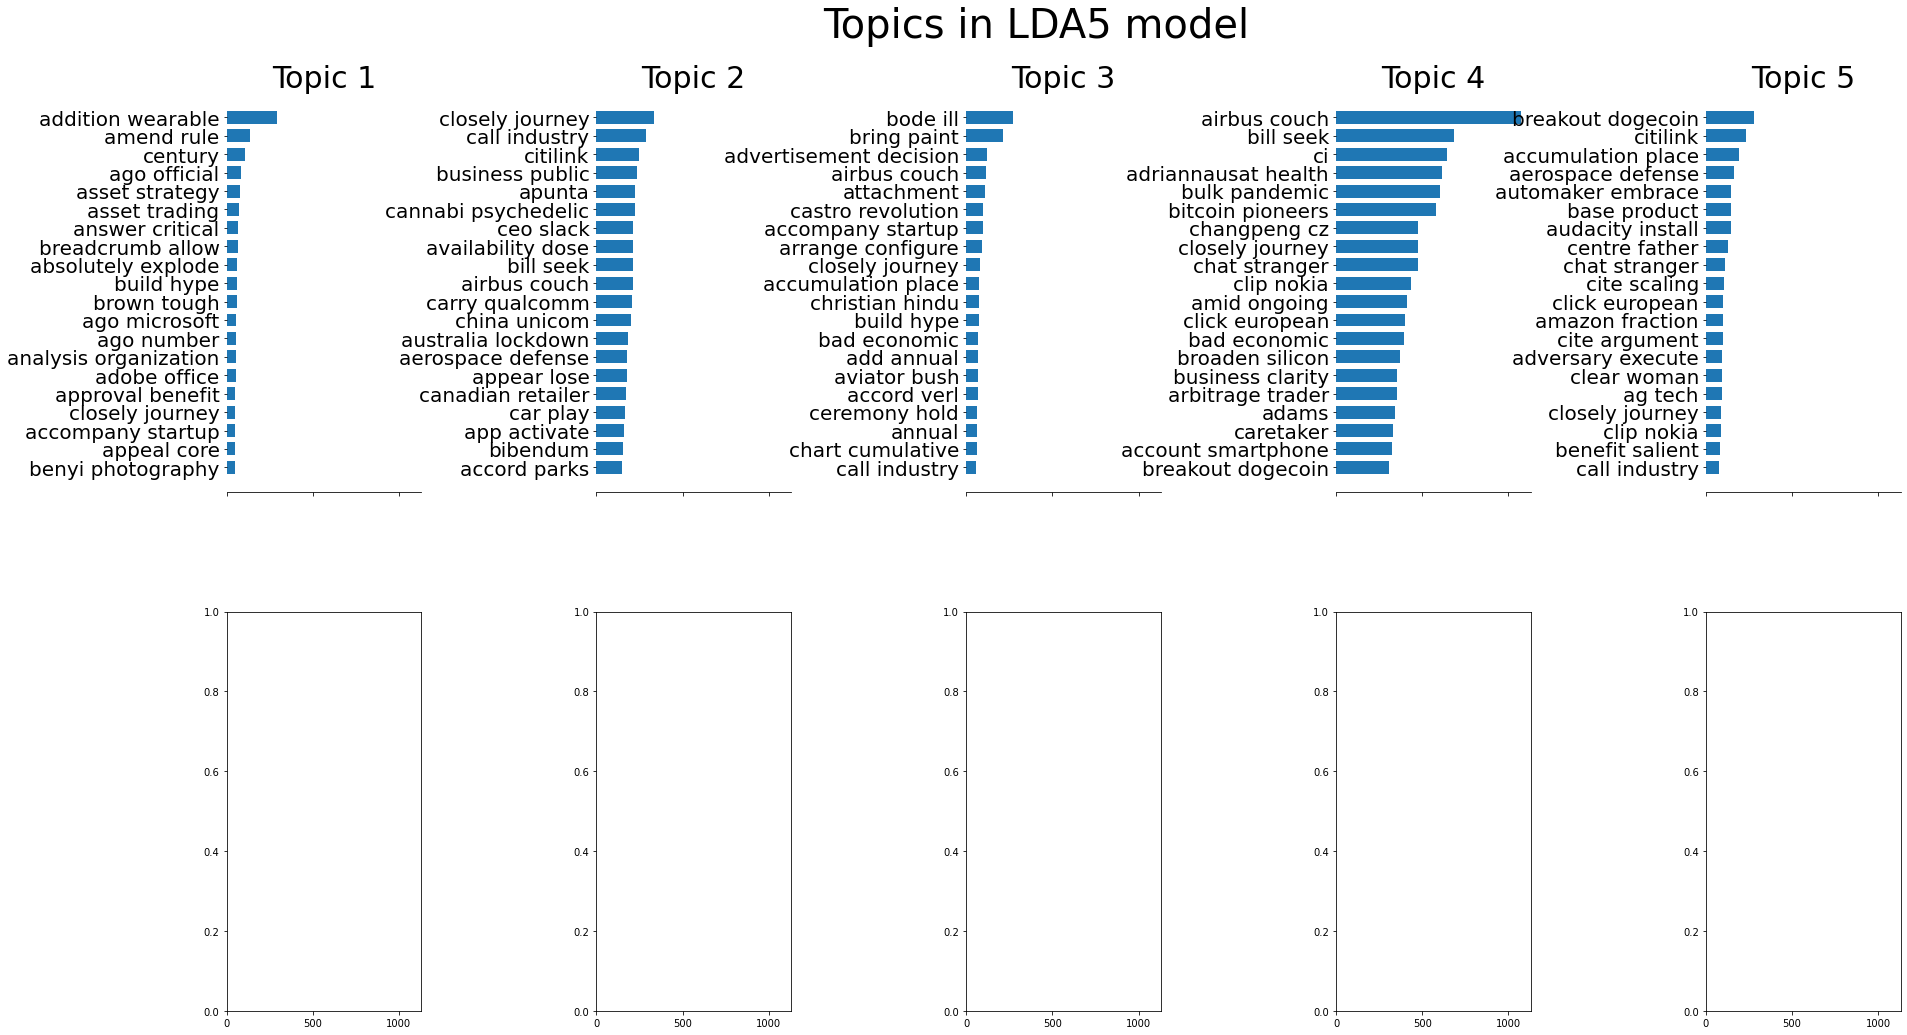

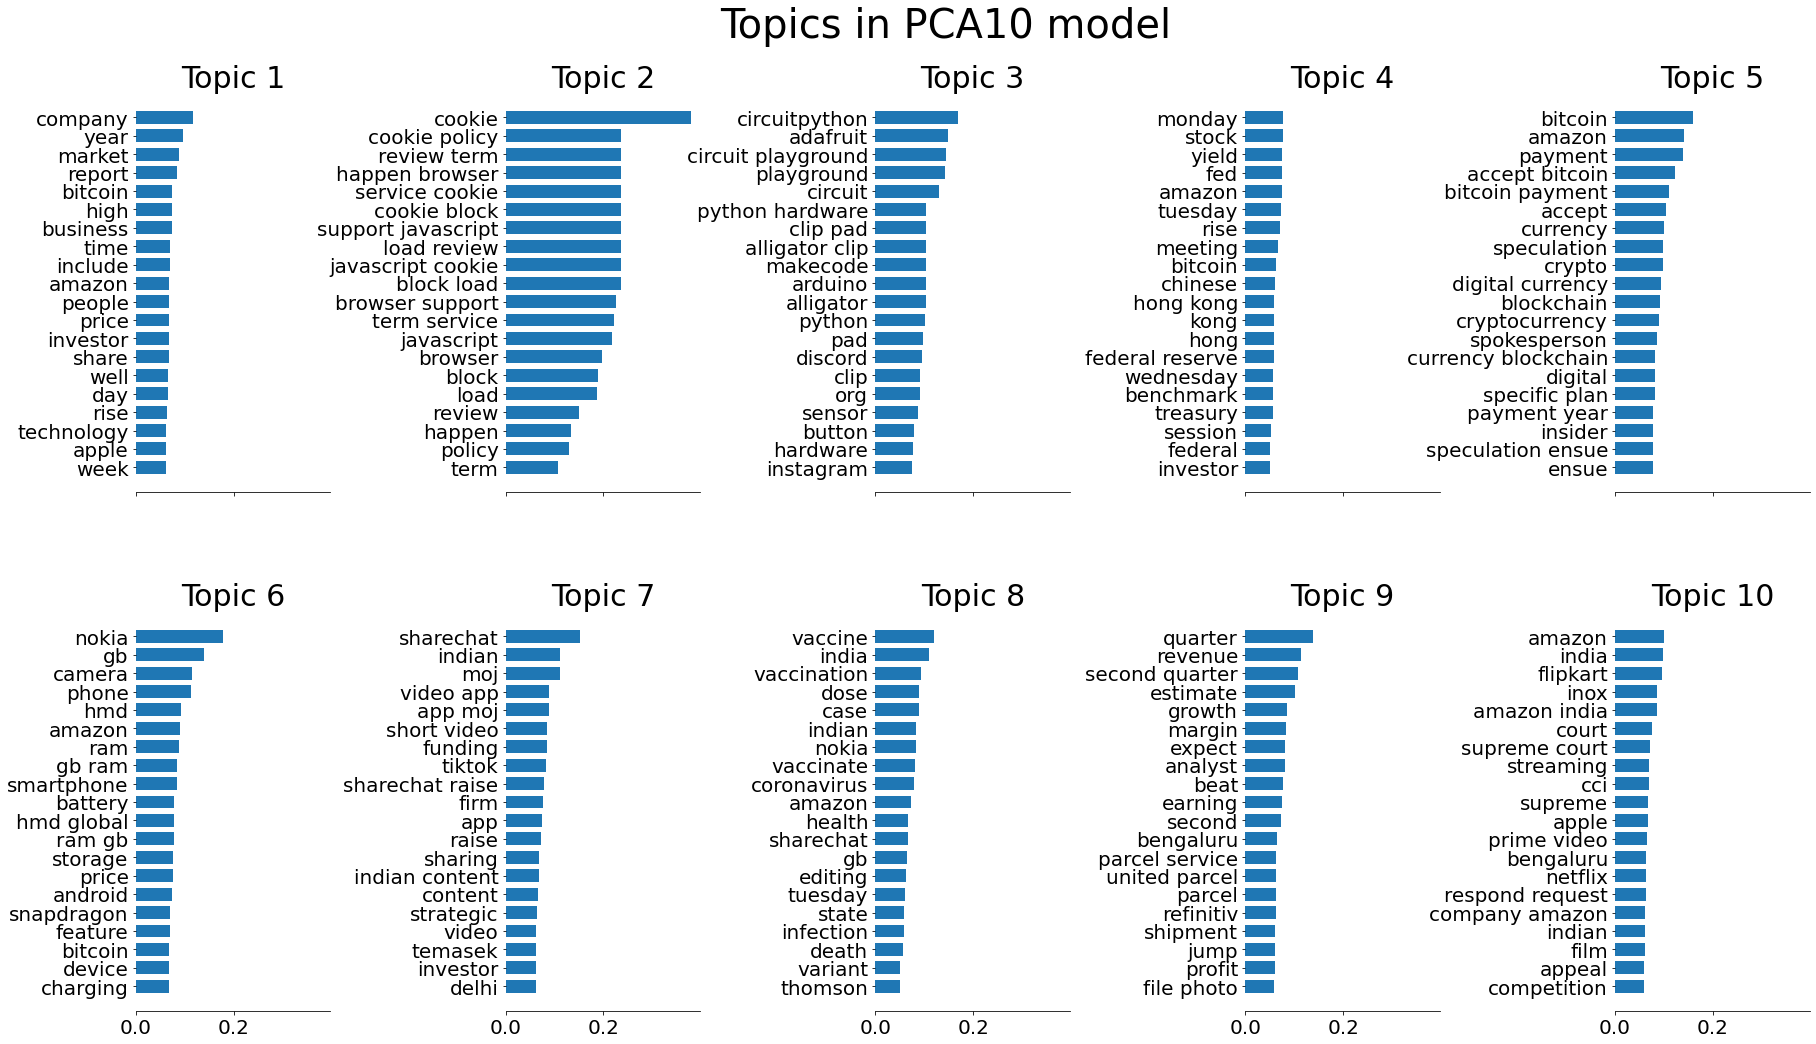

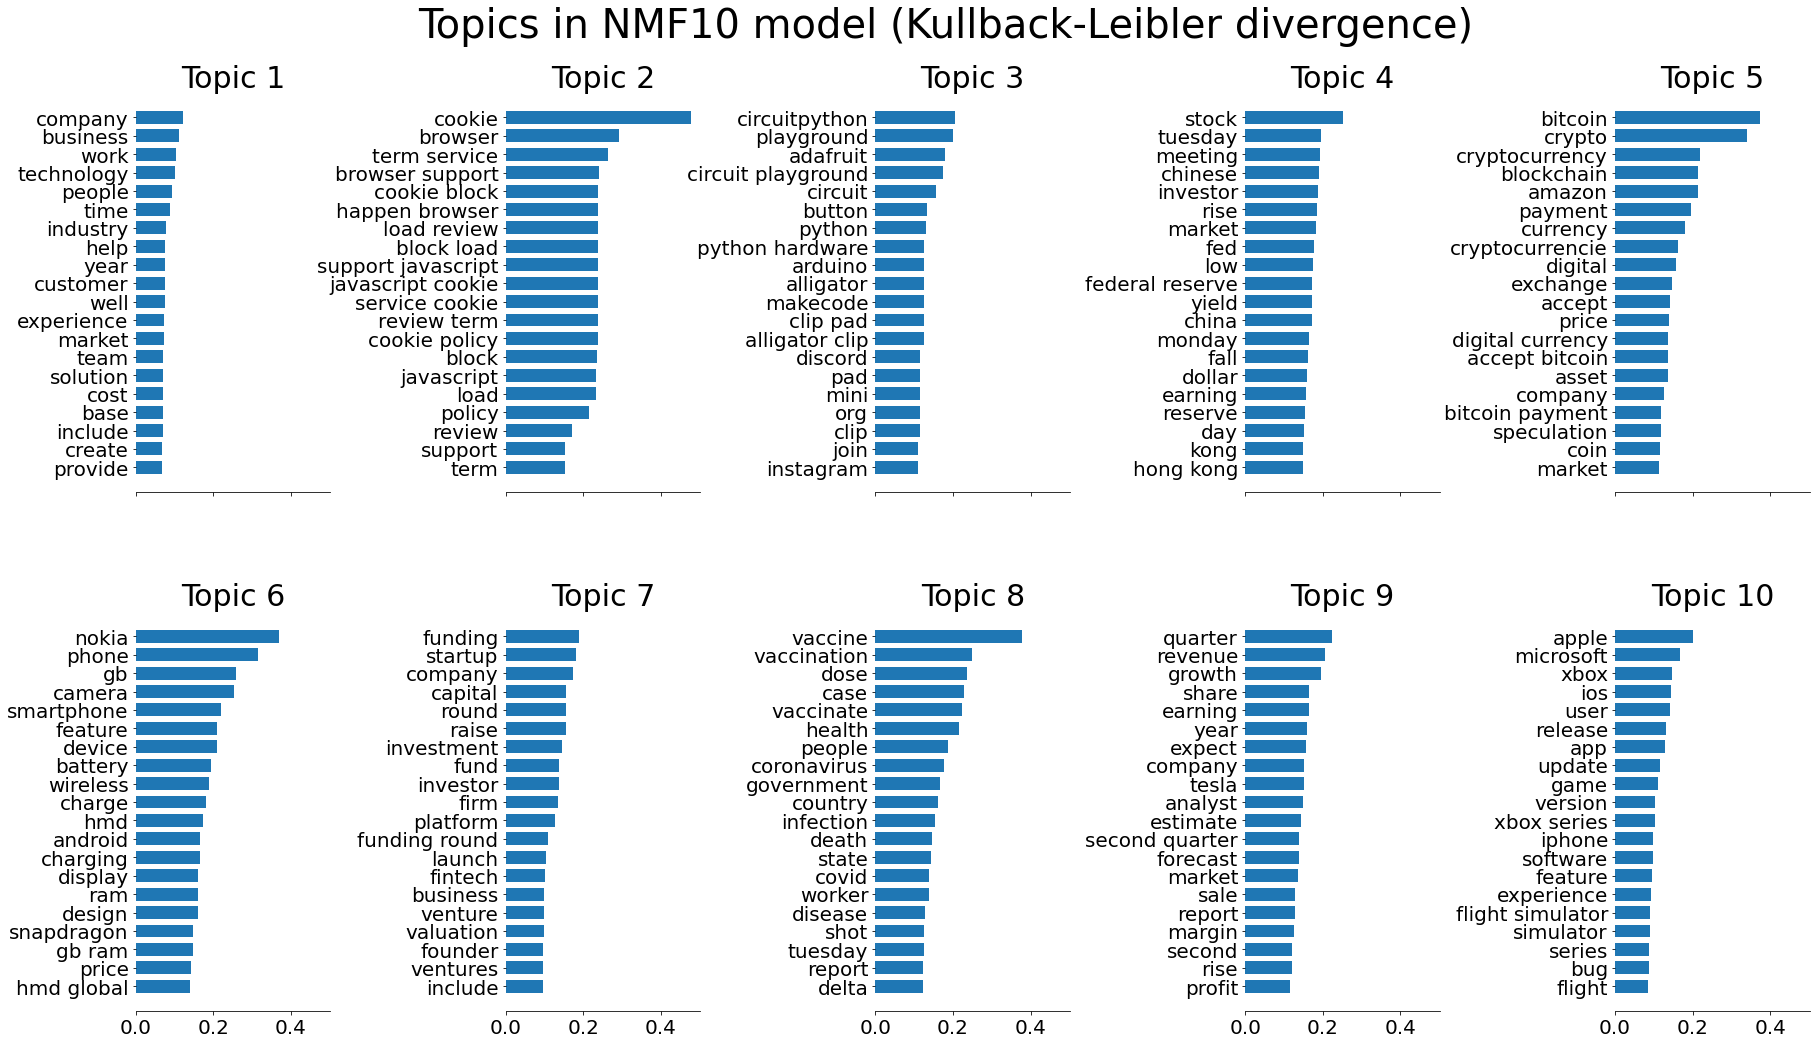

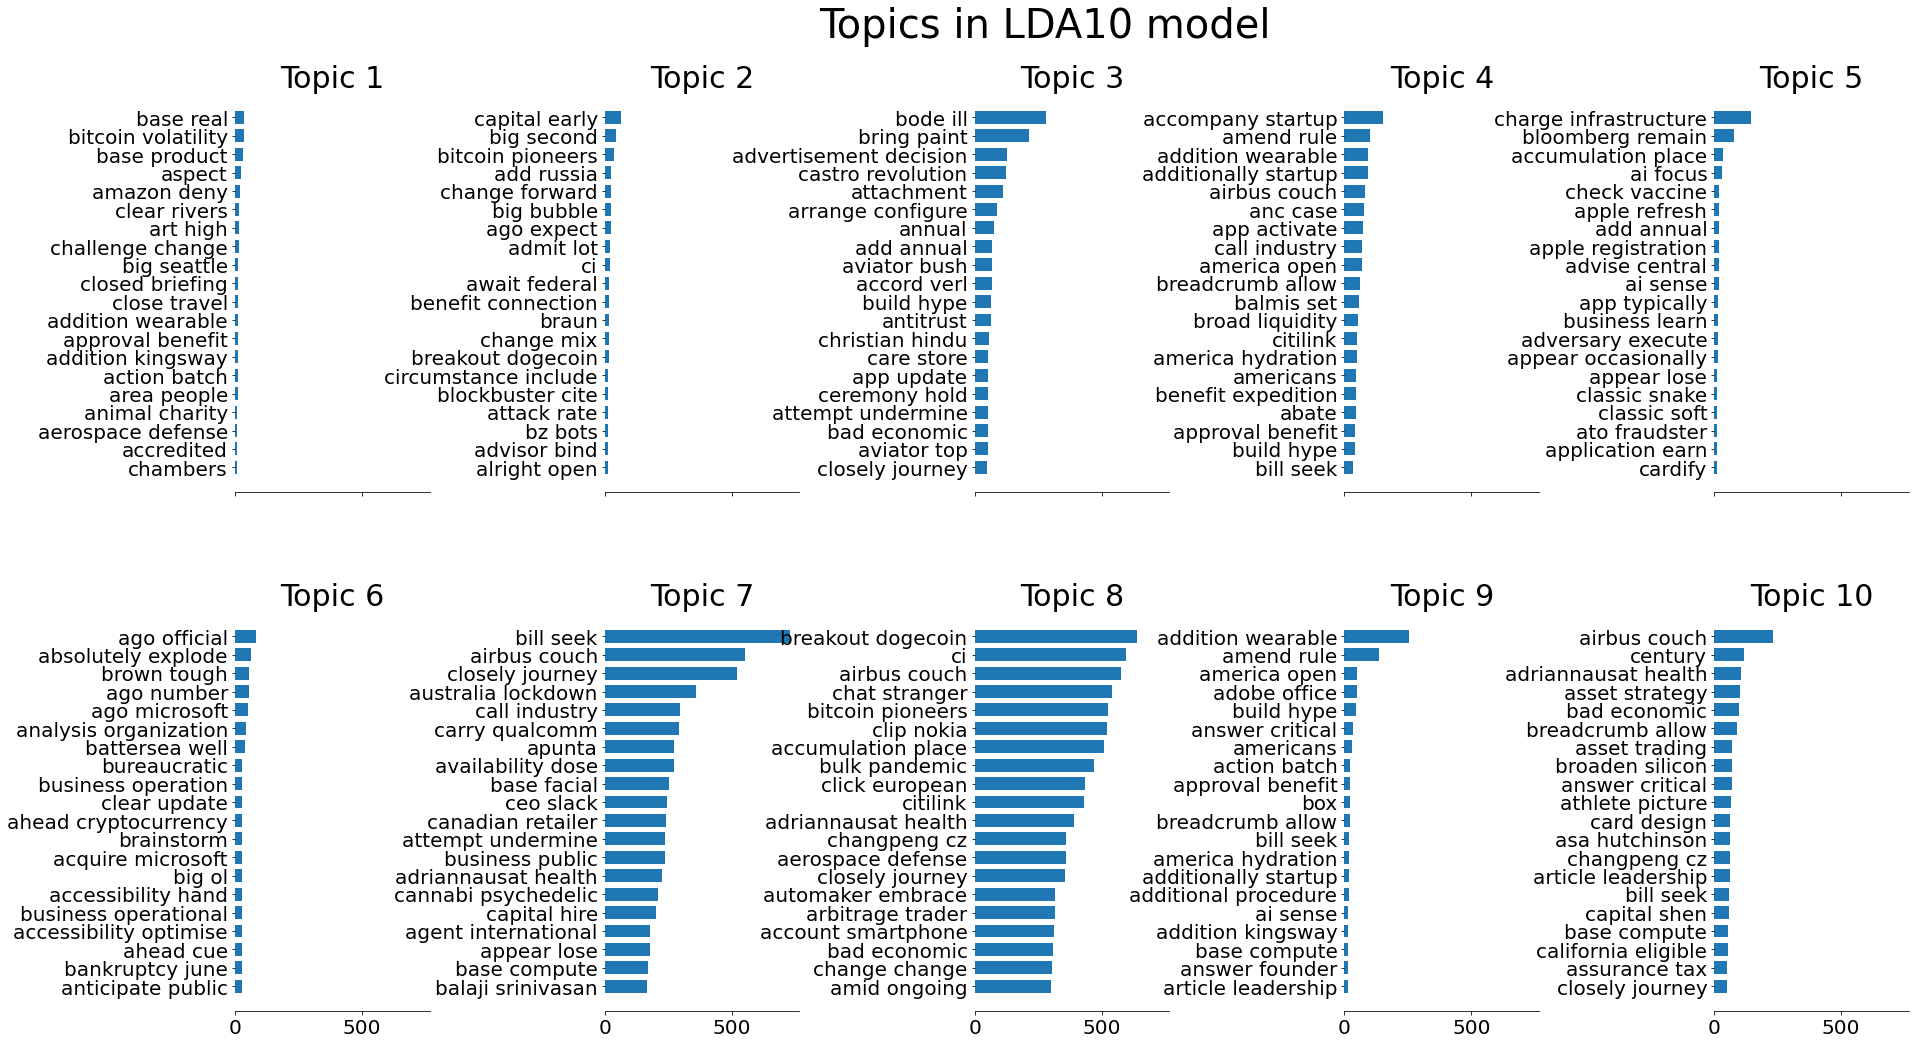

IndexError: index 10 is out of bounds for axis 0 with size 10

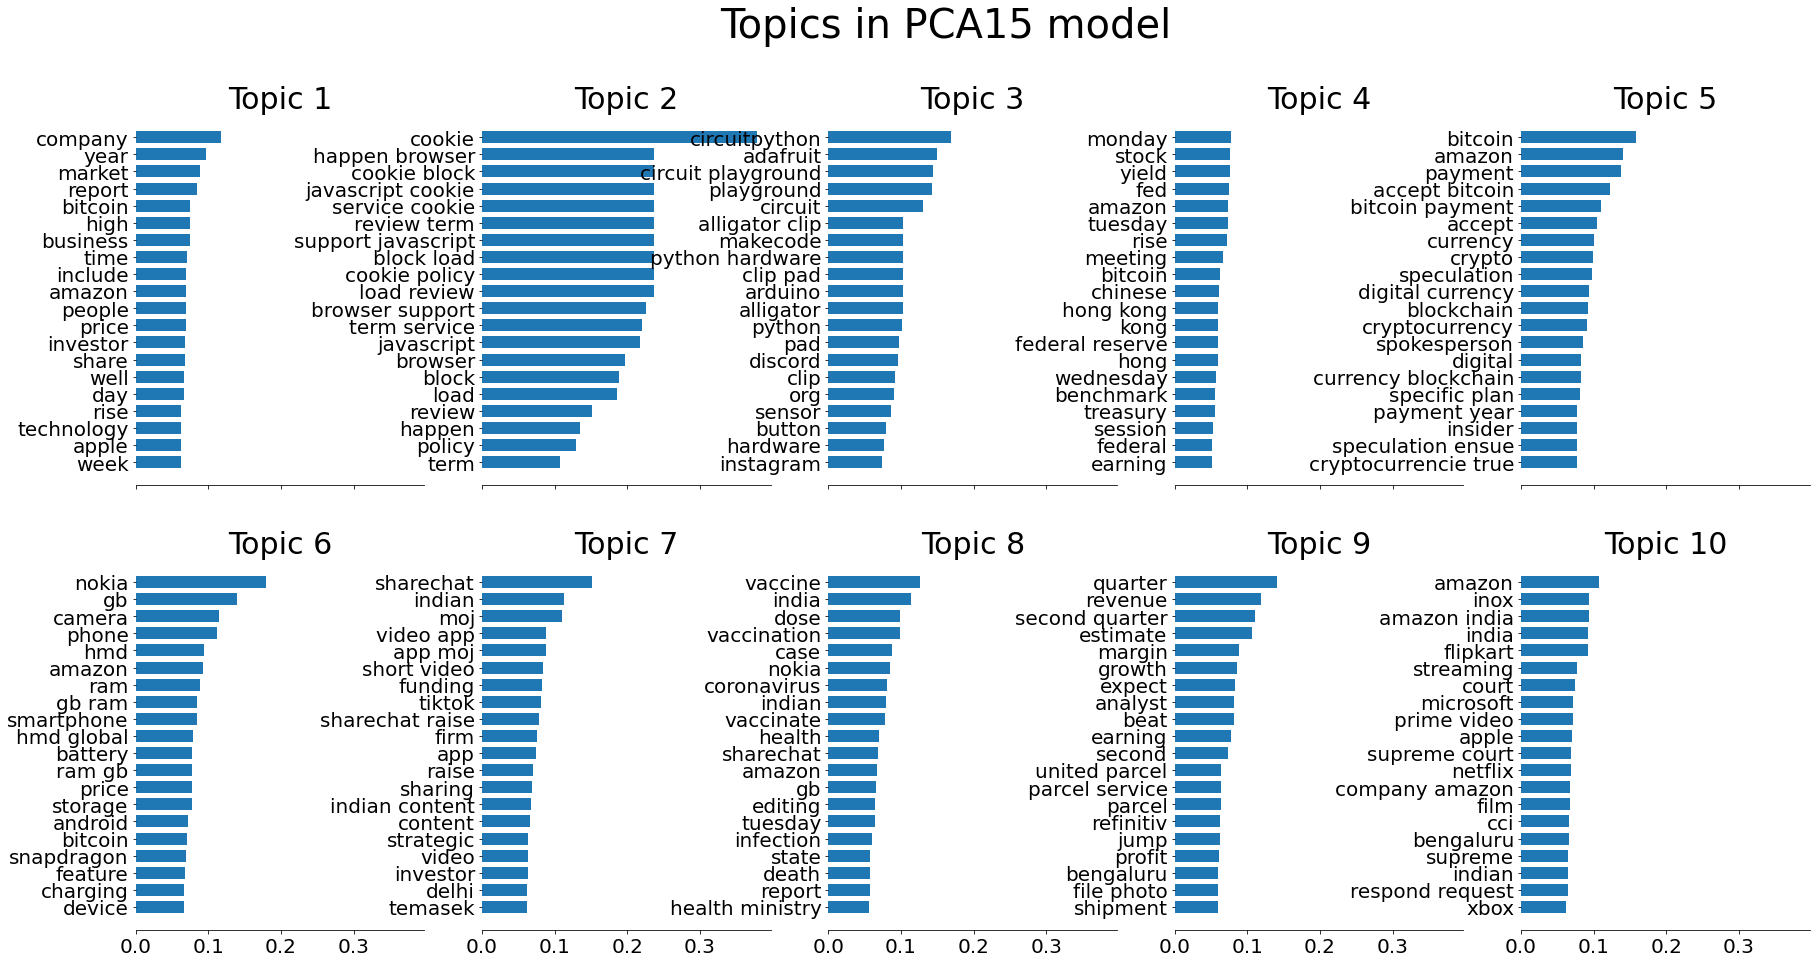

In [11]:
# 8.3. Show topics as vertical plots regarding frequency of tokens 
plot_top_words(pca5, feature_names, 20,
                'Topics in PCA5 model')
plot_top_words(nmf5, feature_names, 20,
               'Topics in NMF5 model (Kullback-Leibler divergence)')
plot_top_words(lda5, feature_names, 20,
               'Topics in LDA5 model')
print()
plot_top_words(pca10, feature_names, 20,
                'Topics in PCA10 model')
plot_top_words(nmf10, feature_names, 20,
               'Topics in NMF10 model (Kullback-Leibler divergence)')
plot_top_words(lda10, feature_names, 20,
               'Topics in LDA10 model')
print()
plot_top_words(pca50, feature_names, 20,
                'Topics in PCA50 model')
plot_top_words(nmf50, feature_names, 20,
               'Topics in NMF50 model (Kullback-Leibler divergence)')
plot_top_words(lda50, feature_names, 20,
               'Topics in LDA50 model')

In [ ]:
# Look at vectors - for debugging purposes
print(f"PCA5 vectors:\n {tf_svd5}")
print(f"NMF5 vectors:\n {tf_nmf5}")
print(f"LDA5 vectors:\n {tf_lda5}")
print('\n')
print(f"PCA5 vectors similarity:\n {linear_kernel(tf_svd5)}")
print(f"NMF5 vectors similarity:\n {linear_kernel(tf_nmf5)}")
print(f"LDA5 vectors similarity:\n {linear_kernel(tf_lda5)}")

In [11]:
#9. Recommend an article

## Clear Tfidf
get_recommendation(0, articles, tf, linear_kernel, text_repr="Clear TfIdf")

print()
## PCA
get_recommendation(0, articles, tf_svd5, linear_kernel, text_repr="PCA5")
get_recommendation(0, articles, tf_svd10, linear_kernel, text_repr="PCA10")
get_recommendation(0, articles, tf_svd50, linear_kernel, text_repr="PCA50")

print()
## NMF
get_recommendation(0, articles, tf_nmf5, linear_kernel, text_repr="NMF5")
get_recommendation(0, articles, tf_nmf10, linear_kernel, text_repr="NMF10")
get_recommendation(0, articles, tf_nmf50, linear_kernel, text_repr="NMF50")

print()
## LDA
get_recommendation(0, articles, tf_lda5, linear_kernel, text_repr="LDA5")
get_recommendation(0, articles, tf_lda10, linear_kernel, text_repr="LDA10")
get_recommendation(0, articles, tf_lda50, linear_kernel, text_repr="LDA50")

==Clear TfIdf==
Source article:
Article(topic=crypto, title=Twitter and Amazon Announce Crypto Plans, Following Facebook, description=While Facebook's digital currency remains MIA, Twitter and Amazon are making their own headway in cryptos. url=https://www.businessinsider.com/twitter-amazon-announce-crypto-plans-following-facebook-2021-7)
Recommended articles:
0 Amazon rejects speculation about bitcoin payment plans as untrue, but says it's still exploring crypto 8.7%
1 Amazon denies rumored plans for Bitcoin support 8.5%
2 Amazon Denies Report of Accepting Bitcoin as Payment 7.8%
3 Amazon denies report of accepting bitcoin as payment 7.6%
4 Amazon denies report of accepting bitcoin as payment 7.2%

==PCA5==
Source article:
Article(topic=crypto, title=Twitter and Amazon Announce Crypto Plans, Following Facebook, description=While Facebook's digital currency remains MIA, Twitter and Amazon are making their own headway in cryptos. url=https://www.businessinsider.com/twitter-amazon-announ